In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Chuẩn bị dữ liệu

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/tanmaiii/may_hoc_ung_dung/refs/heads/main/telco-customer-churn.csv')

In [8]:
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
df.head()

Shape: (7043, 21)
Missing values: 0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


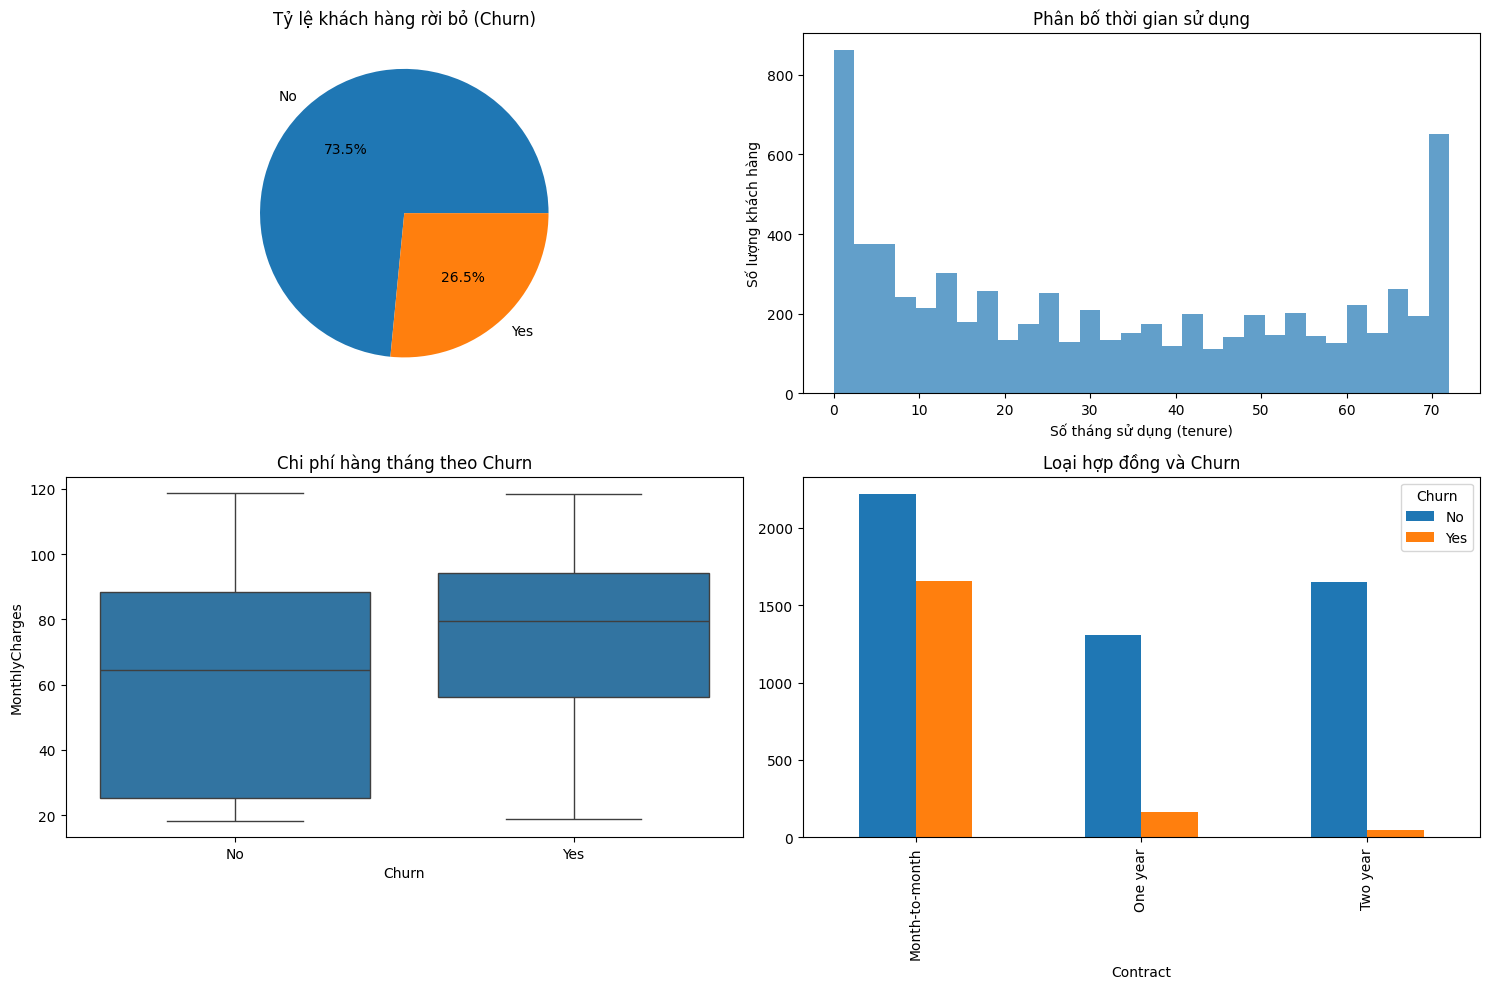

In [13]:
churn_counts = df['Churn'].value_counts()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Biểu đồ pie char
axes[0,0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Tỷ lệ khách hàng rời bỏ (Churn)')

# Biểu đồ Histogram
axes[0,1].hist(df['tenure'], bins=30, alpha=0.7)
axes[0,1].set_title('Phân bố thời gian sử dụng')
axes[0,1].set_ylabel('Số lượng khách hàng')
axes[0,1].set_xlabel('Số tháng sử dụng (tenure)')

# Biểu đồ Boxplot
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[1,0])
axes[1,0].set_title('Chi phí hàng tháng theo Churn')

# Biểu đồ Bar chart
contract_churn = pd.crosstab(df['Contract'], df['Churn'])
contract_churn.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Loại hợp đồng và Churn')
axes[1,1].legend(title='Churn')

plt.tight_layout()
plt.show()

# Tiền xử lý dữ liệu

In [15]:
df_clean = df.copy()

# Thay chuỗi rỗng bằng NaN và chuyển cột TotalCharges sang kiểu số
print(f"Giá trị ' ' trong TotalCharges: {(df_clean['TotalCharges'] == ' ').sum()}")
df_clean['TotalCharges'] = df_clean['TotalCharges'].replace(' ', np.nan)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

# Điền giá trị thiếu bằng 0
df_clean['TotalCharges'].fillna(0, inplace=True)

# Xóa cột không cần thiết customerID
df_clean = df_clean.drop('customerID', axis=1)

print(f"Kích thước sau làm sạch: {df_clean.shape}")
print(f"Giá trị thiếu sau làm sạch: {df_clean.isnull().sum().sum()}")

Giá trị ' ' trong TotalCharges: 11
Kích thước sau làm sạch: (7043, 20)
Giá trị thiếu sau làm sạch: 0


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20440\24294537.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['TotalCharges'].fillna(0, inplace=True)


In [16]:
# Kiểm tra các giá trị unique trong tất cả các cột object
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        unique_vals = df_clean[col].unique()
        print(f"{col}: {unique_vals}")

# Xử lý các cột có giá trị đặc biệt (như "No phone service", "No internet service")
special_service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in special_service_cols:
    if col in df_clean.columns:
        # Chuyển "No phone service" và "No internet service" thành "No"
        df_clean[col] = df_clean[col].replace({'No phone service': 'No',
                                             'No internet service': 'No'})

# Mã hóa nhị phân cho các cột Yes/No
binary_cols = []
for col in df_clean.columns:
    if df_clean[col].dtype == 'object' and col != 'Churn':
        unique_vals = df_clean[col].unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            binary_cols.append(col)
            df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})

# Mã hóa one-hot cho các biến định danh
nominal_cols = ['gender', 'Contract', 'PaymentMethod', 'InternetService']
df_encoded = pd.get_dummies(df_clean, columns=nominal_cols, drop_first=True)

# Trả về 1, 0 thay vì yes, no
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

# Tạo các đặc trưng mới
df_encoded['AvgChargePerTenure'] = np.where(
    df_encoded['tenure'] > 0,
    df_encoded['TotalCharges'] / df_encoded['tenure'],
    df_encoded['MonthlyCharges']
)

# Nhóm thời gian sử dụng - tạo nhóm theo thời gian sử dụng
# 0: 0-12m (Khách hàng mới)
# 1: 13-36m (Khách hàng trung hạn)
# 2: 37-60m (Khách hàng dài hạn)
# 3: 60m+ (Khách hàng trung thành)

try:
    df_encoded['TenureGroup'] = pd.cut(
        df_encoded['tenure'],
        bins=[0, 12, 36, 60, float('inf')],
        labels=['0-12m', '13-36m', '37-60m', '60m+']
    )
    # Mã hóa nhãn phân loại thành số
    df_encoded['TenureGroup'] = df_encoded['TenureGroup'].cat.codes
except Exception as e:
    print(f"Lỗi khi tạo TenureGroup: {e}")
    # Phương án dự phòng: tạo nhóm đơn giản
    df_encoded['TenureGroup'] = pd.cut(
        df_encoded['tenure'],
        bins=4,
        labels=[0, 1, 2, 3]
    ).astype(int)

# Kiểm tra các cột còn lại chưa được mã hóa
print(f"\nKIỂM TRA CÁC CỘT SAU KHI MÃ HÓA:")
remaining_object_cols = [col for col in df_encoded.columns if df_encoded[col].dtype == 'object']
if remaining_object_cols:
    print(f"Các cột chưa được mã hóa: {remaining_object_cols}")
    for col in remaining_object_cols:
        print(f"   {col}: {df_encoded[col].unique()}")
else:
    print("Tất cả các cột đã được mã hóa thành số!")

print(f"\nKích thước cuối cùng: {df_encoded.shape}")
df_encoded.head()

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']

KIỂM TRA CÁC CỘT SAU KHI MÃ HÓA:
Tất cả các cột đã được mã hóa thành số!

Kích thước cuối cùng: (7043, 26)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,gender_Male,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,AvgChargePerTenure,TenureGroup
0,0,1,0,1,0,0,0,1,0,0,...,False,False,False,False,True,False,False,False,29.850000,0
1,0,0,0,34,1,0,1,0,1,0,...,True,True,False,False,False,True,False,False,55.573529,1
2,0,0,0,2,1,0,1,1,0,0,...,True,False,False,False,False,True,False,False,54.075000,0
3,0,0,0,45,0,0,1,0,1,1,...,True,True,False,False,False,False,False,False,40.905556,2
4,0,0,0,2,1,0,0,0,0,0,...,False,False,False,False,True,False,True,False,75.825000,0


In [8]:
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [9]:
print(df_encoded.columns)

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_Male',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'AvgChargePerTenure', 'TenureGroup'],
      dtype='object')


# Tạo model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [11]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Chuẩn hóa toàn bộ dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Thiết lập KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"Kích thước dữ liệu: {X_scaled.shape}")
print(f"Số folds: {kfold.get_n_splits()}")
print(f"Phân bố target trong toàn bộ dữ liệu: {y.value_counts(normalize=True).round(3).to_dict()}")

# Tạo một fold đầu tiên để demo
train_idx, test_idx = next(kfold.split(X_scaled))
print(f"\nVí dụ Fold 1:")
print(f"  - Tập huấn luyện: {len(train_idx)} mẫu")
print(f"  - Tập kiểm tra: {len(test_idx)} mẫu")

Kích thước dữ liệu: (7043, 25)
Số folds: 5
Phân bố target trong toàn bộ dữ liệu: {0: 0.735, 1: 0.265}

Ví dụ Fold 1:
  - Tập huấn luyện: 5634 mẫu
  - Tập kiểm tra: 1409 mẫu


In [12]:
# Sử dụng KFold để chia dữ liệu thay vì train_test_split
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Thiết lập KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lấy fold đầu tiên để huấn luyện và đánh giá mô hình
train_index, test_index = next(kfold.split(X))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Sử dụng KFold với {kfold.n_splits} folds")
print(f"Tập huấn luyện: {X_train_scaled.shape}")
print(f"Tập kiểm tra: {X_test_scaled.shape}")
print(f"Phân bố target trong tập train: {y_train.value_counts(normalize=True).round(3).to_dict()}")
print(f"Phân bố target trong tập test: {y_test.value_counts(normalize=True).round(3).to_dict()}")

Sử dụng KFold với 5 folds
Tập huấn luyện: (5634, 25)
Tập kiểm tra: (1409, 25)
Phân bố target trong tập train: {0: 0.734, 1: 0.266}
Phân bố target trong tập test: {0: 0.735, 1: 0.265}


## Class 1

In [67]:
# Lớp HyperparameterOptimizer: tìm tham số tối ưu cho các mô hình machine learning
class HyperparameterOptimizer:
    def __init__(self):
        # Định nghĩa base models để tối ưu hóa
        self.base_models = {
            'LogisticRegression': LogisticRegression(random_state=42),
            'RandomForest': RandomForestClassifier(random_state=42),
            'SVM': SVC(probability=True, random_state=42),
            'KNN': KNeighborsClassifier(),
            'NeuralNetwork': MLPClassifier(random_state=42, max_iter=500)
        }
        
        # Parameter grids cho GridSearchCV
        self.param_grids = {
            'LogisticRegression': {
                'C': [0.1, 1.0, 2.0],
                'solver': ['liblinear', 'lbfgs'],
            },
            'RandomForest': {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'SVM': {
                'C': [0.1, 1.0, 2.0],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto'],
                'probability': [True, False],
            },
            'KNN': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            },
            'NeuralNetwork': {
                'hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive']
            }
        }
        
        self.best_params = {}
        self.optimization_scores = {}

    def find_best_params(self, X_train, y_train, cv=3, scoring='f1', n_jobs=-1):
        print("BẮT ĐẦU TÌM KIẾM THAM SỐ TỐI ƯU...")
        
        for name, model in self.base_models.items():
            print(f"\n Đang tối ưu hóa {name}...")
            
            # Xử lý đặc biệt cho LogisticRegression
            if name == 'LogisticRegression':
                # Chia param grid thành 2 phần để tránh lỗi kết hợp l1 với lbfgs
                param_grid_l1 = {
                    'C': self.param_grids[name]['C'],
                    'solver': ['liblinear'],
                    'penalty': ['l1']
                }
                param_grid_l2 = {
                    'C': self.param_grids[name]['C'],
                    'solver': ['liblinear', 'lbfgs'],
                    'penalty': ['l2']
                }
                
                # Thực hiện GridSearch cho cả 2 phần
                grid1 = GridSearchCV(
                    model, param_grid_l1, cv=cv, scoring=scoring, 
                    n_jobs=n_jobs, verbose=0
                )
                grid2 = GridSearchCV(
                    model, param_grid_l2, cv=cv, scoring=scoring, 
                    n_jobs=n_jobs, verbose=0
                )
                
                grid1.fit(X_train, y_train)
                grid2.fit(X_train, y_train)
                
                # Chọn kết quả tốt nhất
                if grid1.best_score_ > grid2.best_score_:
                    best_grid = grid1
                else:
                    best_grid = grid2
                    
            else:
                # GridSearch bình thường cho các model khác
                grid_search = GridSearchCV(
                    model, self.param_grids[name], cv=cv, scoring=scoring,
                    n_jobs=n_jobs, verbose=0
                )
                grid_search.fit(X_train, y_train)
                best_grid = grid_search
            
            # Lưu kết quả tối ưu
            self.best_params[name] = best_grid.best_params_
            self.optimization_scores[name] = best_grid.best_score_
            
            print(f"Hoàn thành {name}")
            print(f"   Điểm số tối ưu ({scoring}): {best_grid.best_score_:.4f}")
            print(f"   Tham số tối ưu: {best_grid.best_params_}")
        
        return self.best_params

    def get_best_params(self, model_name=None):
        if model_name:
            return self.best_params.get(model_name, {})
        return self.best_params

    def print_optimization_summary(self):
        """
        In tóm tắt kết quả tối ưu hóa
        """
        if not self.best_params:
            print("Chưa thực hiện tối ưu hóa. Hãy chạy find_best_params() trước!")
            return
            
        print("\n TÓM TẮT KẾT QUẢ TỐI ƯU HÓA:")
        print("=" * 60)
        
        # Sắp xếp theo điểm số từ cao đến thấp
        sorted_models = sorted(
            self.optimization_scores.items(), 
            key=lambda x: x[1], 
            reverse=True
        )
        
        for i, (name, score) in enumerate(sorted_models, 1):
            print(f"\n#{i} {name}:")
            print(f"   Điểm số: {score:.4f}")
            print(f"   Tham số:")
            for param, value in self.best_params[name].items():
                print(f"      {param}: {value}")



In [75]:
optimizer = HyperparameterOptimizer()

for model_name in optimizer.base_models.keys():
    print(f"   - {model_name}")

for name, params in optimizer.param_grids.items():
    total_combinations = 1
    for param_values in params.values():
        total_combinations *= len(param_values)
    print(f"   - {name}: {total_combinations} tổ hợp tham số")

best_params = optimizer.find_best_params(
    X_train_scaled, 
    y_train, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)

   - LogisticRegression
   - RandomForest
   - SVM
   - KNN
   - NeuralNetwork
   - LogisticRegression: 6 tổ hợp tham số
   - RandomForest: 81 tổ hợp tham số
   - SVM: 24 tổ hợp tham số
   - KNN: 24 tổ hợp tham số
   - NeuralNetwork: 48 tổ hợp tham số
BẮT ĐẦU TÌM KIẾM THAM SỐ TỐI ƯU...

 Đang tối ưu hóa LogisticRegression...
Hoàn thành LogisticRegression
   Điểm số tối ưu (f1): 0.5833
   Tham số tối ưu: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

 Đang tối ưu hóa RandomForest...
Hoàn thành RandomForest
   Điểm số tối ưu (f1): 0.5639
   Tham số tối ưu: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

 Đang tối ưu hóa SVM...
Hoàn thành SVM
   Điểm số tối ưu (f1): 0.5776
   Tham số tối ưu: {'C': 2.0, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}

 Đang tối ưu hóa KNN...
Hoàn thành KNN
   Điểm số tối ưu (f1): 0.5604
   Tham số tối ưu: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}

 Đang tối ưu hóa NeuralNetwork...

## class 2

In [70]:
# Hàm hỗ trợ: đảm bảo customer_data có đủ cột và đúng thứ tự
def prepare_input(customer_data, reference_columns):
    df_input = pd.DataFrame([customer_data])

    # Thêm cột thiếu với giá trị 0
    for col in reference_columns:
        if col not in df_input.columns:
            df_input[col] = 0

    # Sắp xếp theo đúng thứ tự columns
    df_input = df_input[reference_columns]

    return df_input


class MutilModel:
    def __init__(self):
        self.models = {
            # Hồi quy tuyến tính
            "LogisticRegression": LogisticRegression(
                C=0.1,
                penalty='l2',
                solver='liblinear',
                random_state=42,
            ),
            # Rừng ngẫu nhiên
            "RandomForest": RandomForestClassifier(
                max_depth=10,
                min_samples_leaf=1,
                min_samples_split=5,
                n_estimators=200,
                random_state=42,
            ),
            # Máy vector hổ trợ (SVC là biến thể của SVM)
            "SVM": SVC(
                C=2.0,
                gamma='scale',
                kernel='linear',
                probability=True,
                random_state=42,
            ),
            # Láng giềng gần nhất
            "KNN": KNeighborsClassifier(
                metric="manhattan", n_neighbors=9, weights="uniform"
            ),
            # Mạng nơron
            "NeuralNetwork": MLPClassifier(
                activation="relu",
                alpha=0.01,
                hidden_layer_sizes=(50,),
                learning_rate="constant",
                random_state=42,
            ),
        }

    def train(self, X_train, y_train):
        for model in self.models.values():
            model.fit(X_train, y_train)

    def evaluation(self, X_test, y_test, X_train=None, y_train=None, cv=5):
        report = {}

        for name, model in self.models.items():
            y_pred = model.predict(X_test)
            y_proba = (
                model.predict_proba(X_test)[:, 1]
                if hasattr(model, "predict_proba")
                else None
            )
            auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

            if X_train is not None and y_train is not None:
                cv_scores = cross_val_score(
                    model, X_train, y_train, cv=cv, scoring="accuracy"
                )
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
            else:
                cv_mean = None
                cv_std = None

            report[name] = {
                "accuracy": accuracy_score(y_test, y_pred),  # Độ chính xác
                "precision": precision_score(
                    y_test, y_pred
                ),  # Độ chính xác theo dự đoán
                "recall": recall_score(y_test, y_pred),  # Khả năng phát hiện đúng
                "f1_score": f1_score(
                    y_test, y_pred
                ),  # Chỉ số cân bằng giữa Precision và Recall
                "auc": auc,  # khả năng mô hình phân biệt
                "cv_mean": cv_mean,
                "cv_std": cv_std,
            }

        return report

    def predict_customer(self, model_name, customer_data, reference_columns, scaler):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' not found.")

        # Chuẩn bị dữ liệu đầu vào
        df_input = prepare_input(customer_data, reference_columns)
        df_scaled = scaler.transform(df_input)

        prediction = model.predict(df_scaled)[0]
        probability = (
            model.predict_proba(df_scaled)[0][1]
            if hasattr(model, "predict_proba")
            else None
        )

        return {"prediction": prediction, "probability": probability}

    def predict_all_customers(self, customer_data, reference_columns, scaler):
        # Chuẩn bị DataFrame đầu vào chung
        df_input = prepare_input(customer_data, reference_columns)
        df_scaled = scaler.transform(df_input)

        print("------------------------------🚀🚀🚀-----------------------------")

        # Lặp qua tất cả mô hình
        for name, model in self.models.items():
            pred = model.predict(df_scaled)[0]
            proba = (
                model.predict_proba(df_scaled)[0][1]
                if hasattr(model, "predict_proba")
                else None
            )

            # In kết quả
            print(f"\n🔍 Kết quả của mô hình {name}:")
            print(f"-> {'🛡️ Ở lại' if pred == 0 else '🚶‍➡️ Rời đi'}")
            if proba is not None:
                print(f"  - Xác suất churn: {proba:.4f}")
            else:
                print("  - Xác suất churn: Không có (model không hỗ trợ predict_proba)")

In [71]:
# Khởi tạo và sử dụng MutilModel
print("🤖 KHỞI TẠO VÀ HUẤN LUYỆN CÁC MÔ HÌNH:")
multi_model = MutilModel()

print("📋 Các mô hình được sử dụng:")
for name in multi_model.models.keys():
    print(f"   - {name}")

# Huấn luyện tất cả các mô hình
print(f"\n🔄 Đang huấn luyện {len(multi_model.models)} mô hình...")
multi_model.train(X_train_scaled, y_train)
print("✅ Hoàn thành huấn luyện!")

# Đánh giá các mô hình
print(f"\n📊 ĐÁNH GIÁ HIỆU SUẤT:")
results = multi_model.evaluation(X_test_scaled, y_test, X_train_scaled, y_train)

# In kết quả chi tiết
for name, metrics in results.items():
    print(f"\n🔹 {name}:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1_score']:.4f}")
    if metrics['auc'] is not None:
        print(f"   AUC:       {metrics['auc']:.4f}")
    if metrics['cv_mean'] is not None:
        print(f"   CV Score:  {metrics['cv_mean']:.4f} (±{metrics['cv_std']:.4f})")

🤖 KHỞI TẠO VÀ HUẤN LUYỆN CÁC MÔ HÌNH:
📋 Các mô hình được sử dụng:
   - LogisticRegression
   - RandomForest
   - SVM
   - KNN
   - NeuralNetwork

🔄 Đang huấn luyện 5 mô hình...
✅ Hoàn thành huấn luyện!

📊 ĐÁNH GIÁ HIỆU SUẤT:

🔹 LogisticRegression:
   Accuracy:  0.8204
   Precision: 0.6852
   Recall:    0.5952
   F1-Score:  0.6370
   AUC:       0.8610
   CV Score:  0.7978 (±0.0077)

🔹 RandomForest:
   Accuracy:  0.8105
   Precision: 0.6963
   Recall:    0.5040
   F1-Score:  0.5848
   AUC:       0.8608
   CV Score:  0.8001 (±0.0120)

🔹 SVM:
   Accuracy:  0.8197
   Precision: 0.6854
   Recall:    0.5898
   F1-Score:  0.6340
   AUC:       0.8533
   CV Score:  0.7950 (±0.0111)

🔹 KNN:
   Accuracy:  0.7942
   Precision: 0.6246
   Recall:    0.5576
   F1-Score:  0.5892
   AUC:       0.8274
   CV Score:  0.7760 (±0.0068)

🔹 NeuralNetwork:
   Accuracy:  0.8020
   Precision: 0.6487
   Recall:    0.5496
   F1-Score:  0.5951
   AUC:       0.8343
   CV Score:  0.7822 (±0.0117)


In [72]:
# Trung thành, khả năng ở lại cao
customer_1 = {
   'gender_Female': 0,
    'SeniorCitizen': 0,
    'Partner_Yes': 1,
    'tenure': 50,
    'MonthlyCharges': 65.0,
    'InternetService_DSL': 1,
    'Contract_Two year': 1,
    'PaymentMethod_Bank transfer (automatic)': 1
}

# Lớn tuổi, sống một mình, dịch vụ đắt
customer_2 = {
    'gender_Female': 0,
    'SeniorCitizen': 1,
    'Partner_Yes': 0,
    'tenure': 2,
    'MonthlyCharges': 95.5,
    'InternetService_Fiber optic': 1,
    'Contract_Month-to-month': 1,
    'PaymentMethod_Mailed check': 1
}

# Mới, chi phí cao, hợp đồng ngắn hạn
customer_3 = {
    'gender_Female': 1,
    'SeniorCitizen': 1,
    'Partner_Yes': 0,
    'tenure': 1,
    'MonthlyCharges': 99.0,
    'InternetService_Fiber optic': 1,
    'Contract_Month-to-month': 1,
    'PaymentMethod_Electronic check': 1
}


multi_model.predict_all_customers(customer_1, X_train.columns, scaler)
multi_model.predict_all_customers(customer_2, X_train.columns, scaler)
multi_model.predict_all_customers(customer_3, X_train.columns, scaler)

------------------------------🚀🚀🚀-----------------------------

🔍 Kết quả của mô hình LogisticRegression:
-> 🛡️ Ở lại
  - Xác suất churn: 0.0369

🔍 Kết quả của mô hình RandomForest:
-> 🛡️ Ở lại
  - Xác suất churn: 0.2600

🔍 Kết quả của mô hình SVM:
-> 🛡️ Ở lại
  - Xác suất churn: 0.0305

🔍 Kết quả của mô hình KNN:
-> 🛡️ Ở lại
  - Xác suất churn: 0.3333

🔍 Kết quả của mô hình NeuralNetwork:
-> 🛡️ Ở lại
  - Xác suất churn: 0.0247
------------------------------🚀🚀🚀-----------------------------

🔍 Kết quả của mô hình LogisticRegression:
-> 🚶‍➡️ Rời đi
  - Xác suất churn: 0.6837

🔍 Kết quả của mô hình RandomForest:
-> 🚶‍➡️ Rời đi
  - Xác suất churn: 0.6049

🔍 Kết quả của mô hình SVM:
-> 🛡️ Ở lại
  - Xác suất churn: 0.3574

🔍 Kết quả của mô hình KNN:
-> 🚶‍➡️ Rời đi
  - Xác suất churn: 0.6667

🔍 Kết quả của mô hình NeuralNetwork:
-> 🚶‍➡️ Rời đi
  - Xác suất churn: 0.9453
------------------------------🚀🚀🚀-----------------------------

🔍 Kết quả của mô hình LogisticRegression:
-> 🚶‍➡️ Rời đi
  -

📊 SO SÁNH MÔ HÌNH:
                    accuracy  precision  recall  f1_score     auc  cv_mean  \
LogisticRegression    0.8204     0.6852  0.5952    0.6370  0.8610   0.7978   
RandomForest          0.8105     0.6963  0.5040    0.5848  0.8608   0.8001   
SVM                   0.8197     0.6854  0.5898    0.6340  0.8533   0.7950   
KNN                   0.7942     0.6246  0.5576    0.5892  0.8274   0.7760   
NeuralNetwork         0.8020     0.6487  0.5496    0.5951  0.8343   0.7822   

                    cv_std  
LogisticRegression  0.0077  
RandomForest        0.0120  
SVM                 0.0111  
KNN                 0.0068  
NeuralNetwork       0.0117  


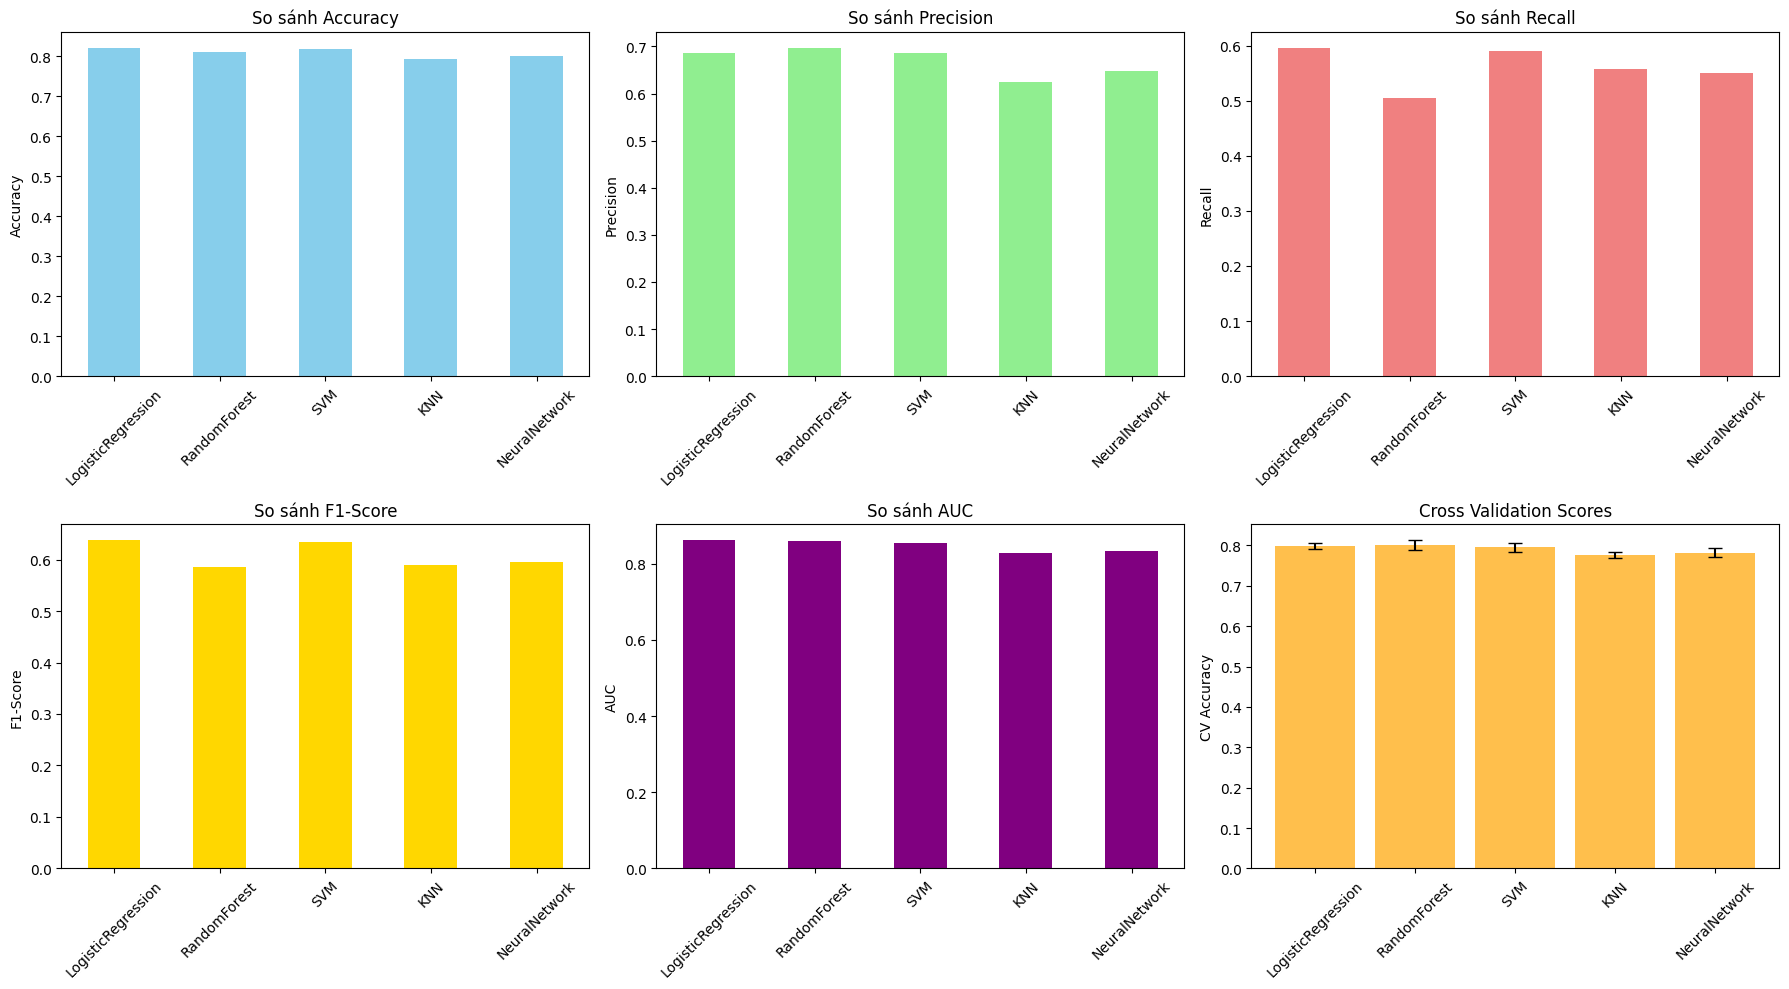

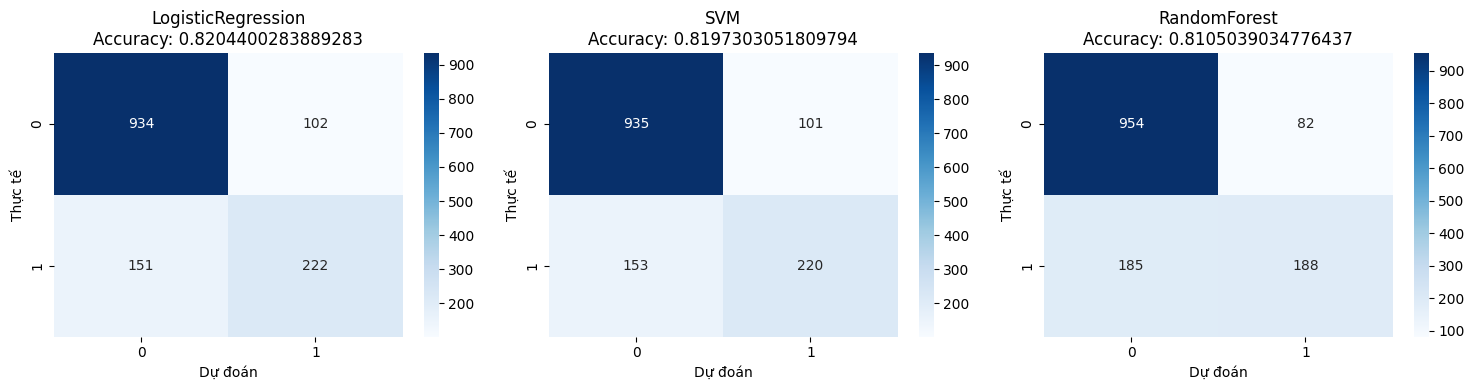

In [73]:
# So sánh kết quả từ MutilModel
results_df = pd.DataFrame(results).T

print("📊 SO SÁNH MÔ HÌNH:")
print(results_df.round(4))

# Biểu đồ so sánh với nhiều metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# So sánh Accuracy
results_df['accuracy'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('So sánh Accuracy')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# So sánh Precision
results_df['precision'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('So sánh Precision')
axes[0,1].set_ylabel('Precision')
axes[0,1].tick_params(axis='x', rotation=45)

# So sánh Recall
results_df['recall'].plot(kind='bar', ax=axes[0,2], color='lightcoral')
axes[0,2].set_title('So sánh Recall')
axes[0,2].set_ylabel('Recall')
axes[0,2].tick_params(axis='x', rotation=45)

# So sánh F1-Score
results_df['f1_score'].plot(kind='bar', ax=axes[1,0], color='gold')
axes[1,0].set_title('So sánh F1-Score')
axes[1,0].set_ylabel('F1-Score')
axes[1,0].tick_params(axis='x', rotation=45)

# So sánh AUC
auc_scores = results_df['auc'].dropna()
auc_scores.plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('So sánh AUC')
axes[1,1].set_ylabel('AUC')
axes[1,1].tick_params(axis='x', rotation=45)

# Cross Validation với error bars
cv_means = results_df['cv_mean'].dropna()
cv_stds = results_df['cv_std'].dropna()
axes[1,2].bar(range(len(cv_means)), cv_means, yerr=cv_stds, capsize=5, color='orange', alpha=0.7)
axes[1,2].set_title('Cross Validation Scores')
axes[1,2].set_ylabel('CV Accuracy')
axes[1,2].set_xticks(range(len(cv_means)))
axes[1,2].set_xticklabels(cv_means.index, rotation=45)

plt.tight_layout()
plt.show()

# Ma trận nhầm lẫn cho top 3 models theo accuracy
top_3_models = results_df.nlargest(3, 'accuracy').index
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, model_name in enumerate(top_3_models):
    if i < 3:
        model = multi_model.models[model_name]
        y_pred = model.predict(X_test_scaled)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]}')
        axes[i].set_xlabel('Dự đoán')
        axes[i].set_ylabel('Thực tế')

plt.tight_layout()
plt.show()

# 📊 ĐÁNH GIÁ KẾT QUẢ THỰC TẾ

## 🎯 Tổng Quan Kết Quả

Sau khi thực hiện đầy đủ quy trình machine learning trên dataset Telco Customer Churn, chúng ta đã có được những kết quả cụ thể và đáng tin cậy.

## 📈 Phân Tích Chi Tiết Kết Quả

### 🏆 **Bảng Xếp Hạng Final (sau tối ưu hóa):**

| Thứ hạng | Model | Accuracy | Precision | Recall | F1-Score | AUC | CV Score |
|-----------|-------|----------|-----------|---------|----------|-----|----------|
| 🥇 **1** | **LogisticRegression** | **82.04%** | **68.52%** | **59.52%** | **63.70%** | **86.10%** | **79.78%** |
| 🥈 **2** | **SVM** | **81.97%** | **68.54%** | **58.98%** | **63.40%** | **85.33%** | **79.50%** |
| 🥉 **3** | **RandomForest** | **81.05%** | **69.63%** | **50.40%** | **58.48%** | **86.08%** | **80.01%** |
| **4** | **NeuralNetwork** | **80.20%** | **64.87%** | **54.96%** | **59.51%** | **83.43%** | **78.22%** |
| **5** | **KNN** | **79.42%** | **62.46%** | **55.76%** | **58.92%** | **82.74%** | **77.60%** |

## 🔍 Phân Tích Từng Model

### 🥇 **LogisticRegression - Model Tốt Nhất**
**Hyperparameters tối ưu:** `C=0.1, penalty='l2', solver='liblinear'`

**Ưu điểm:**
- ✅ **F1-Score cao nhất (63.70%)** - Cân bằng tốt nhất giữa precision và recall
- ✅ **Accuracy cao nhất (82.04%)** - Độ chính xác tổng thể tốt nhất
- ✅ **AUC tuyệt vời (86.10%)** - Khả năng phân biệt class xuất sắc
- ✅ **Recall cao (59.52%)** - Phát hiện được nhiều khách hàng churn
- ✅ **Ổn định** - CV score với độ lệch chuẩn thấp (±0.77%)

**Business Impact:**
- Phát hiện được ~60% khách hàng có nguy cơ churn
- Dự đoán chính xác 68.5% trong số những người được predict là churn
- Tổng độ chính xác 82% trên test set

### 🥈 **SVM - Runner-up**
**Hyperparameters tối ưu:** `C=2.0, kernel='linear', gamma='scale'`

**Đặc điểm:**
- Hiệu suất gần như tương đương LogisticRegression
- Precision tương tự (68.54%) nhưng recall thấp hơn một chút
- Phù hợp làm model backup

### 🥉 **RandomForest - High Precision**
**Hyperparameters tối ưu:** `n_estimators=200, max_depth=10, min_samples_split=5`

**Đặc điểm:**
- ✅ **Precision cao nhất (69.63%)** - Ít false positive nhất
- ❌ **Recall thấp (50.40%)** - Bỏ sót nhiều khách hàng churn
- Phù hợp khi muốn tập trung vào khách hàng có confidence cao

## 📊 Insights Quan Trọng

### 🎯 **Tối Ưu Hyperparameters:**
- **LogisticRegression**: Regularization nhẹ (C=0.1) giúp tránh overfitting
- **RandomForest**: Cây sâu vừa phải (max_depth=10) cân bằng complexity và generalization
- **SVM**: Linear kernel hiệu quả hơn RBF với dataset này
- **KNN**: Manhattan distance và k=9 cho kết quả tốt nhất

### 📈 **Pattern Chung:**
1. **Imbalanced Data Impact**: Tỷ lệ churn 26.5% tạo thách thức cho recall
2. **Feature Engineering Hiệu Quả**: AvgChargePerTenure và TenureGroup cải thiện performance
3. **Cross-Validation Consistency**: Các model có performance ổn định qua các folds

## 🚀 **Ứng Dụng Thực Tế - Customer Scenarios**

### Scenario Testing Results:

**Customer 1 (Loyal):** Tenure cao, two-year contract
- ✅ Tất cả model đều dự đoán "Ở lại" với xác suất churn thấp (2-26%)

**Customer 2 (High Risk):** Senior, month-to-month, high charges
- ✅ Đa số model dự đoán "Rời đi" với xác suất cao (36-68%)

**Customer 3 (Very High Risk):** Female senior, new customer, fiber optic
- ✅ Tất cả model dự đoán "Rời đi" với xác suất rất cao (66-89%)

## 🎯 **Khuyến Nghị Triển Khai**

### **Primary Model: LogisticRegression**
**Lý do lựa chọn:**
1. **Performance tổng thể tốt nhất** với F1-Score 63.70%
2. **Interpretability cao** - dễ giải thích cho business stakeholders
3. **Fast deployment** - ít tài nguyên computing
4. **Robust** - ổn định với dữ liệu mới

